# analysis

In [ ]:
#| default_exp analysis

In [ ]:
#| export
import numpy as np
import math

In [ ]:
#| hide
import matplotlib.pyplot as plt
from nbdev import show_doc
from andi_datasets.models_phenom import models_phenom

# Angle calculation

In [ ]:
#| export 
def get_angle(a:tuple, # 2d position point A
              b:tuple, # 2d position point B
              c:tuple # 2d position point C       
             ) -> tuple:  # angle between segments AB and BC points
                
    ''' Calculates the angle between the segments generate by three points '''
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang

def dataset_angles(trajs:list, # set of trajectories from which to calculate angles
                  ) -> list: # list of angles between displacements
    '''Given a set of trajectories, calculate all angles between displacements'''
    angles = []
    for traj in trajs:
        for a, b, c in zip(traj[:, :-2].transpose(), traj[:, 1:-1].transpose(), traj[:, 2:].transpose()):
            angles.append(get_angle(a, b, c))
    return angles

# MSD based analysis 

In [ ]:
#| export
class msd_analysis():
    def __init__(self):
        ''' Contains mean squared displacement (MSD) based methods to analyze trajectories.  '''
        

    def tamsd(self, 
              traj:np.ndarray, 
              t_lags:np.ndarray):
        '''
        Calculates the time average mean squared displacement (TA-MSD) of a trajectory at various time lags,
        
        Parameters
        ----------
        traj : np.array
            Trajectory from whicto calculate TA-MSD.
        
        t_lags : list | np.array
            Time lags used for the TA-MSD
        
        Returns       
        ----------
        np.array
            TA-MSD of the given trayectory
            
        '''
        tamsd = np.zeros_like(t_lags, dtype= float)
        for idx, t in enumerate(t_lags):        
            for p in range(len(traj)-t):
                tamsd[idx] += (traj[p]-traj[p+t])**2            
            tamsd[idx] /= len(traj)-t    
        return tamsd

    def get_diff_coeff(self, 
                       traj:np.ndarray, 
                       t_lags:list = None):
        '''
        Calculates the diffusion coefficient of a trajectory by means of the linear
        fitting of the TA-MSD.
        
        Parameters
        ----------
        traj : np.array
            1D trajectory from whicto calculate TA-MSD.
        
        t_lags : bool | list
            Time lags used for the TA-MSD.
        
        Returns       
        ----------
        np.array
            Diffusion coefficient of the given trajectory.          
        
        '''
        if not t_lags:
            N_t_lags = max(4, int(len(traj)*0.1))
            t_lags = np.arange(1, N_t_lags)

        tasmd = self.tamsd(traj, t_lags)
        return np.polyfit(t_lags, tasmd, deg = 1)[0]/2

    def get_exponent(self, 
                     traj,
                     t_lags:list = None):
        '''
        Calculates the anolaous of a trajectory by means of the linear
        fitting of the logarithm of the TA-MSD.
        
        Parameters
        ----------
        traj : np.array
            1D trajectory from whicto calculate TA-MSD.
        
        t_lags : bool, list 
            Time lags used for the TA-MSD.
        
        Returns       
        ----------
        np.array
            Anomalous exponent of the given trajectory.          
        
        '''
        
        if not t_lags:
            N_t_lags = max(4, int(len(traj)*0.1))
            t_lags = np.arange(1, N_t_lags)

        tasmd = self.tamsd(traj, t_lags)
        return np.polyfit(np.log(t_lags), np.log(tasmd), deg = 1)[0]
    
    

In [ ]:
show_doc(msd_analysis.tamsd)

In [ ]:
show_doc(msd_analysis.get_diff_coeff)

Here we show an example for the calculation of a Brownian motion trajectory. We create 100 trajectories from displacements of variance $\sigma =1$, which results in a diffusion coefficient $D=0.5$.

<matplotlib.legend.Legend>

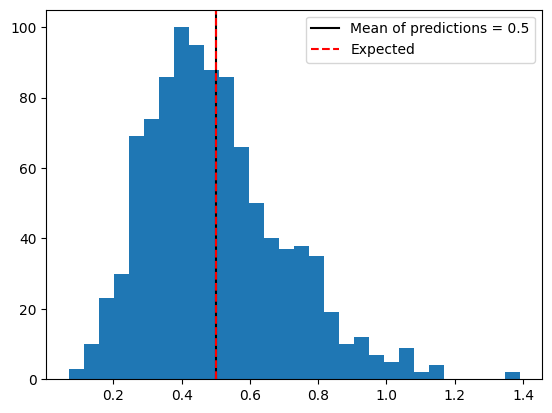

In [ ]:
D = []
for _ in range(1000):    
    pos = np.cumsum(np.random.randn(100))
    D.append(msd_analysis().get_diff_coeff(pos))
    
plt.hist(D, bins = 30);
plt.axvline(np.mean(D), c = 'k', label = f'Mean of predictions = {np.round(np.mean(D), 2)}')                                                                  
plt.axvline(0.5, c = 'r', ls = '--', label = 'Expected')
plt.legend()

In [ ]:
show_doc(msd_analysis.get_exponent)

To showcase this function, we generate fractional brownian motion trajectories with $\alpha = 0.5$ and calculate their exponent:

<matplotlib.legend.Legend>

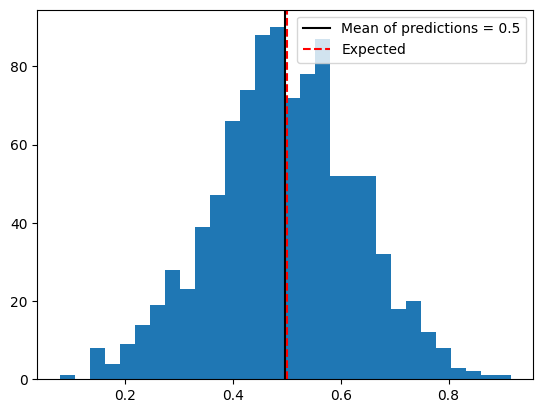

In [ ]:
alpha = []
trajs, _ = models_phenom().single_state(N = 1000, T = 100, alphas = 0.5) 
for traj in trajs.transpose(1,0,2):    
    alpha.append(msd_analysis().get_exponent(traj[:,0]))
    
plt.hist(alpha, bins = 30);
plt.axvline(np.mean(alpha), c = 'k', label = f'Mean of predictions = {np.round(np.mean(alpha), 2)}')
plt.axvline(0.5, c = 'r', ls = '--', label = 'Expected')
plt.legend()

# Velocity Autocorrelation Function (VACF)

In [ ]:
#| export
def vacf(trajs, 
         delta_t:int | list | np.ndarray  = 1, 
         taus:bool | list | np.ndarray = None):
    '''
    Calculates the velocity autocorrelation function for 
    the given set of trajectories.
    
    Parameters
    ----------
    trajs : np.array
     NxT matrix containing N trajectories of length T.
        
    delta_t : int | list | array
     If not None, the vacf is calculated in the demanded time lags. 
        
    taus : bool |  list | array
     Time windows at wich the vacf is calculated. 
    
    Returns
    ----------
    np.array
        VACF of the given trajectories and the given time windows.        
    '''
    if isinstance(delta_t, int): delta_t = [delta_t]
    
    if taus is None: taus = np.arange(1, trajs.shape[1]).astype(int)
        
    V = np.zeros((len(delta_t), len(taus)))
    for idx_d, delta in enumerate(delta_t):
        # Calculate the velocity
        velocity = trajs[: ,delta:] - trajs[:,:-delta]
        velocity /= delta_t   
    
    
        for idx_t, tau in enumerate(taus):
            if tau == 0:
                V[idx_d, idx_t] = (velocity**2).mean()
            else:
                V[idx_d, idx_t] = (velocity[:, :-tau]*velocity[:, tau:]).mean()
        V[idx_d, :] /= V[idx_d, 0]
        
    return V

We show here an example of the VACF for FBM trajectories at various time lages, showing that they all coincide (as expected for this diffusion model).

Text(0.5, 0, '$\\tau / \\delta$')

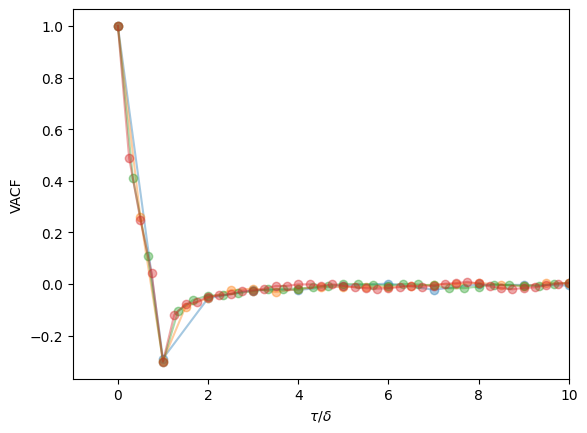

In [ ]:
deltats = np.arange(1, 5).tolist()
taus = np.arange(0, 100)
trajs, _ = models_phenom().single_state(N = 200, T = 200, alphas = 0.5)
trajs = trajs.transpose(1, 0, 2)[:,:,0]

for deltat in deltats:  
    v = vacf(trajs, deltat, taus)        
    plt.plot(taus/deltat, v.flatten(), 'o-', alpha = 0.4)    
plt.xlim(-1, 10)
plt.ylabel('VACF'); plt.xlabel(r'$\tau / \delta$')

# Convex hull analysis

In [ ]:
#| export
from scipy.spatial import ConvexHull

def CH_changepoints(trajs, 
                    tau:int = 10, 
                    metric:{'volume', 'area'} = 'volume'):
    ''' 
    Computes the changes points a multistate trajectory based on the Convex Hull approach proposed in PRE 96 (022144), 2017.
    
    Parameters
    ----------
    trajs : np.array
     NxT matrix containing N trajectories of length T.
        
    tau : int
     Time window over which the CH is calculated.
        
    metric : {'volume', 'area'} 
     Calculate change points w.r.t. area or volume of CH.
    
    Returns
    ----------
    list
        Change points of the given trajectory.
    '''
    
    CPs = []
    for traj in trajs:
        traj = np.array(traj)

        Sd = np.zeros(traj.shape[0]-2*tau)
        for k in range(traj.shape[0]-2*tau):
            if metric == 'volume':
                Sd[k] = ConvexHull(traj[k:(k+2*tau)]).volume
            elif metric == 'area':
                Sd[k] = ConvexHull(traj[k:(k+2*tau)]).area

        below_mean = Sd < Sd.mean()
        cp_traj = np.argwhere(below_mean[1:] != below_mean[:-1])+1
        CPs.append(cp_traj+tau)

    return CPs

We showcase the use of the convex hull in a Brownian motion trajectory with two distinct diffusion coefficients, one 10 times the other:

Text(0, 0.5, '$S_d(n)$')

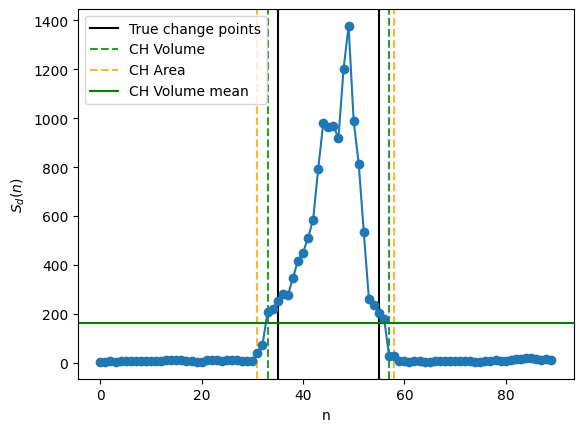

In [ ]:
# Generate trajectories and plot change points
T = 100; on = 40; off = 60;
traj = np.random.randn(T, 2)
traj[on:off, :] = traj[on:off, :]*10
traj = traj.cumsum(0)
plt.axvline(on-tau, c = 'k')
plt.axvline(off-tau, c = 'k', label = 'True change points')

# Calculate variable Sd 
tau = 5
Sd = np.zeros(traj.shape[0]-2*tau)
for k in range(traj.shape[0]-2*tau):       
    Sd[k] = ConvexHull(traj[k:(k+2*tau)], ).volume  

# Compute change points both with volume and area
CPs = CH_changepoints([traj], tau = tau)[0].flatten()-tau
CPs_a = CH_changepoints([traj], tau = tau, metric = 'area')[0].flatten()-tau


# Plot everything
label_cp = 'CH Volume'
for cp in CPs:
    plt.axvline(cp, c = 'g', alpha = 0.8, ls = '--', label = label_cp)
    label_cp = ''
label_cp = 'CH Area'    
for cp in CPs_a:
    plt.axvline(cp, alpha = 0.8, ls = '--', c = 'orange', label = label_cp)
    label_cp = ''
    
plt.plot(Sd, '-o')
plt.axhline(Sd.mean(), label = 'CH Volume mean', c = 'g',)
plt.legend()
plt.xlabel('n'); plt.ylabel(r'$S_d(n)$')

#| hide
# Export

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()